In [ ]:
# Temporal Pointwise Convolutional Networks (TPC) Example
# Complete tutorial for using TPC with PyHealth

"""
TPC Model Example for PyHealth
===============================

This example demonstrates how to use the Temporal Pointwise Convolutional Networks (TPC)
model for length of stay prediction in healthcare settings.

Paper: "Temporal Pointwise Convolutional Networks for Length of Stay Prediction
       in the Intensive Care Unit" (Rocheteau et al., CHIL 2021)
Paper https://arxiv.org/pdf/2007.09483
Implementation Authors: Zakaria Coulibaly
NetID: zakaria5

Key Features:
- Handles irregular time sampling naturally
- Multi-scale temporal pattern recognition
- Feature interactions via pointwise convolutions
- Suitable for ICU and EHR data
"""

In [ ]:
# ==============================================================================
# 1. SET UP
# ==============================================================================

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pyhealth.datasets import SampleDataset, split_by_patient, get_dataloader
from pyhealth.models import TPC
from pyhealth.trainer import Trainer
from pyhealth.processors import SequenceProcessor

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.2.2
CUDA available: False


In [ ]:
# ==============================================================================
# 2. DATA PREPARATION
# ==============================================================================

In [2]:
def create_synthetic_icu_data(num_samples=1000, seed=42):
    """
    Create synthetic ICU patient data for demonstration.

    In production, replace this with your actual data loading logic.
    Example data sources:
    - MIMIC-III/MIMIC-IV
    - eICU
    - Your institution's EHR data

    Args:
        num_samples (int): Number of patient samples to generate
        seed (int): Random seed for reproducibility

    Returns:
        list: List of patient sample dictionaries
    """
    np.random.seed(seed)

    samples = []
    for i in range(num_samples):
        # Random number of diagnosis codes (1-10)
        num_conditions = np.random.randint(1, 11)
        conditions = np.random.randint(1, 100, size=num_conditions).tolist()

        # Random number of procedure codes (0-5)
        num_procedures = np.random.randint(0, 6)
        procedures = (np.random.randint(1, 50, size=num_procedures).tolist()
                     if num_procedures > 0 else [0])

        # Length of stay (1-30 days), correlated with number of conditions
        # This simulates the clinical reality where sicker patients stay longer
        base_los = 2 + num_conditions * 0.5
        los = max(1.0, base_los + np.random.randn() * 2)

        samples.append({
            "patient_id": f"patient-{i}",
            "visit_id": f"visit-{i}",
            "conditions": conditions,
            "procedures": procedures,
            "label": los
        })

    return samples

# Create synthetic dataset
print("Creating synthetic ICU dataset...")
samples = create_synthetic_icu_data(num_samples=1000)


# Create PyHealth SampleDataset
dataset = SampleDataset(
    samples=samples,
    dataset_name="icu_los_prediction",
    task_name="length_of_stay",
    input_schema={
        "conditions": SequenceProcessor,  # ICD codes or similar
        "procedures": SequenceProcessor   # CPT codes or similar
    },
    output_schema={"label": "regression"}  # Continuous LoS prediction
)

print(f"Dataset created with {len(dataset)} samples")
print(f"Sample example:", dataset.samples[0])

Creating synthetic ICU dataset...


Processing samples: 100%|██████████| 1000/1000 [00:00<00:00, 29797.34it/s]

Dataset created with 1000 samples
Sample example: {'patient_id': 'patient-0', 'visit_id': 'visit-0', 'conditions': tensor([1, 2, 3, 4, 5, 6, 7]), 'procedures': tensor([1, 2]), 'label': tensor([3.7295])}


In [ ]:
# ==============================================================================
# 3. DATA ANALYSIS
# ==============================================================================

In [3]:
# Analyze dataset statistics
labels = np.array([sample["label"] for sample in dataset.samples]).ravel()
num_conditions = np.array([len(sample["conditions"]) for sample in dataset.samples]).ravel()
num_procedures = np.array([len(sample["procedures"]) for sample in dataset.samples]).ravel()

print("\nDataset Statistics:")
print("-" * 40)
print(f"Total samples: {len(dataset)}")
print(f"\nLength of Stay:")
print(f"  Mean: {np.mean(labels):.2f} days")
print(f"  Median: {np.median(labels):.2f} days")
print(f"  Std: {np.std(labels):.2f} days")
print(f"  Range: [{np.min(labels):.2f}, {np.max(labels):.2f}]")
print(f"\nConditions per patient:")
print(f"  Mean: {np.mean(num_conditions):.2f}")
print(f"  Range: [{np.min(num_conditions)}, {np.max(num_conditions)}]")
print(f"\nProcedures per patient:")
print(f"  Mean: {np.mean(num_procedures):.2f}")
print(f"  Range: [{np.min(num_procedures)}, {np.max(num_procedures)}]")


Dataset Statistics:
----------------------------------------
Total samples: 1000

Length of Stay:
  Mean: 4.82 days
  Median: 4.86 days
  Std: 2.15 days
  Range: [1.00, 12.74]

Conditions per patient:
  Mean: 5.43
  Range: [1, 10]

Procedures per patient:
  Mean: 2.72
  Range: [1, 5]


In [ ]:
# ==============================================================================
# 4. DATA VISUALIZATION
# ==============================================================================

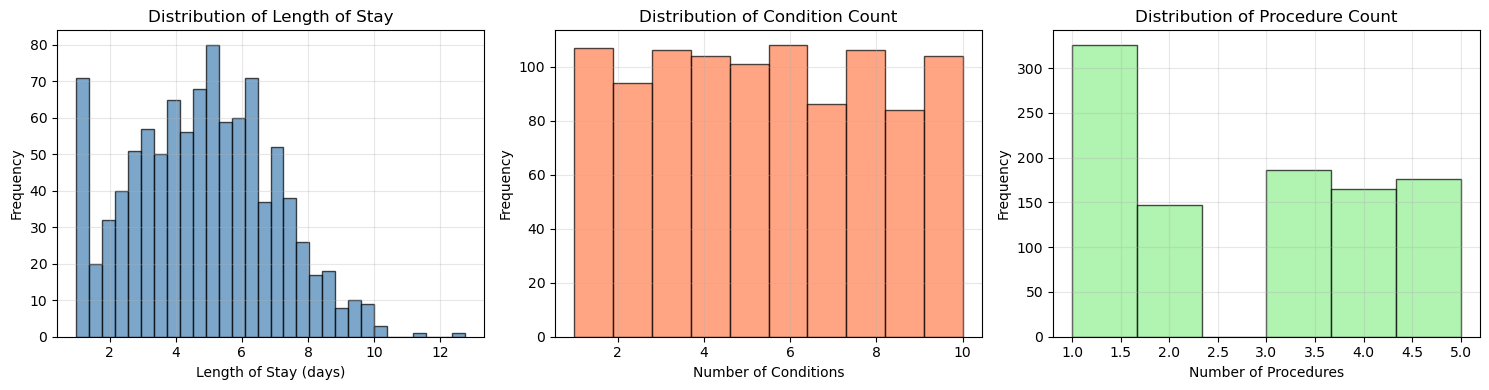

In [4]:
labels = np.array(labels).ravel()
num_conditions = np.array(num_conditions).ravel()
num_procedures = np.array(num_procedures).ravel()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Length of stay distribution
axes[0].hist(labels, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Length of Stay (days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Length of Stay')
axes[0].grid(True, alpha=0.3)

# Number of conditions
axes[1].hist(num_conditions, bins=10, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Number of Conditions')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Condition Count')
axes[1].grid(True, alpha=0.3)

# Number of procedures
axes[2].hist(num_procedures, bins=6, edgecolor='black', alpha=0.7, color='lightgreen')
axes[2].set_xlabel('Number of Procedures')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Procedure Count')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# 5. SPLITING THE DATA INTO TRAIN/VAL/TEST
# ==============================================================================

In [7]:
# Split dataset into train/val/test
train_dataset, val_dataset, test_dataset = split_by_patient(
    dataset,
    ratios=[0.7, 0.15, 0.15],
    seed=42
)

print(f"\nDataset Split:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")


Dataset Split:
  Training samples: 700
  Validation samples: 150
  Test samples: 150


In [5]:
# ==============================================================================
# 6. LOADING THE DATA INTO DATALOADERS
# ==============================================================================

In [8]:
# Create dataloaders
train_loader = get_dataloader(train_dataset, batch_size=32, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=32, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

print(f"\nDataLoader Batches:")
print(f"  Training: {len(train_loader)} batches")
print(f"  Validation: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")



DataLoader Batches:
  Training: 22 batches
  Validation: 5 batches
  Test: 5 batches


In [78]:
# ==============================================================================
# 7. MODEL INITIALIZATION
# ==============================================================================

In [10]:
# Initialize TPC model with hyperparameters from the paper
model = TPC(
    dataset=dataset,
    embedding_dim=128,          # Embedding dimension for medical codes
    num_layers=3,               # Number of TPC blocks (default from paper)
    num_filters=8,              # Filters per temporal convolution (paper default)
    pointwise_channels=128,     # Channels for pointwise convolutions (paper default)
    kernel_size=4,              # Temporal convolution kernel size (paper default)
    dropout=0.3,                # Dropout rate (paper default)
)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n TPC Model Initialized")
print("-" * 40)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

print("\nModel Architecture:")
print(f"  Input features: {model.feature_keys}")
print(f"  Embedding dimension: {model.embedding_dim}")
print(f"  Number of TPC blocks: {model.num_layers}")
print(f"  Task mode: {model.mode}")

# Print detailed architecture
print("\nTPC Block Configuration:")
for i, block in enumerate(model.tpc_blocks, 1):
    print(f"  Layer {i}:")
    print(f"    - Input channels: {block.input_channels}")
    print(f"    - Output channels: {block.output_channels}")
    print(f"    - Dilation: {block.dilation}")


 TPC Model Initialized
----------------------------------------
Total parameters: 4,764,545
Trainable parameters: 4,764,545
Model size: ~18.18 MB

Model Architecture:
  Input features: ['conditions', 'procedures']
  Embedding dimension: 128
  Number of TPC blocks: 3
  Task mode: regression

TPC Block Configuration:
  Layer 1:
    - Input channels: 256
    - Output channels: 2432
    - Dilation: 1
  Layer 2:
    - Input channels: 2432
    - Output channels: 22016
    - Dilation: 4
  Layer 3:
    - Input channels: 22016
    - Output channels: 198272
    - Dilation: 7


In [ ]:
# ==============================================================================
# 8. MODEL TRAINING
# ==============================================================================

In [13]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nTraining on device: {device}")

# Initialize trainer
trainer = Trainer(
    model=model,
    device=device,
    metrics=["mae", "mse"],           # Track MAE and MSE during training
    enable_logging=True,              # Enable training logs
    output_path="./outputs/tpc_los"   # Save model checkpoints here
)

print("\n Trainer initialized")
print(f" Metrics: {trainer.metrics}")

# Train the model
print("\nStarting training...")
print("-" * 40)

trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=5,                        # Number of training epochs
    monitor="mae",                   # Monitor MAE for early stopping
    monitor_criterion="min",         # Lower MAE is better
    patience=5,                      # Stop if no improvement for 5 epochs
    load_best_model_at_last=True     # Load best model after training
)

print("\n Training completed!")


Training on device: cpu
TPC(
  (embedding_model): EmbeddingModel(embedding_layers=ModuleDict(
    (conditions): Embedding(101, 128, padding_idx=0)
    (procedures): Embedding(52, 128, padding_idx=0)
  ))
  (tpc_blocks): ModuleList(
    (0): TPCBlock(
      (temporal_conv): Conv1d(256, 2048, kernel_size=(4,), stride=(1,), groups=256)
      (bn_temporal): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise_conv): Linear(in_features=256, out_features=128, bias=True)
      (bn_pointwise): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_temporal): Dropout(p=0.3, inplace=False)
      (dropout_pointwise): Dropout(p=0.3, inplace=False)
    )
    (1): TPCBlock(
      (temporal_conv): Conv1d(2432, 19456, kernel_size=(4,), stride=(1,), dilation=(4,), groups=2432)
      (bn_temporal): BatchNorm1d(19456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pointwise_conv): Linear(in_fea

Epoch 0 / 5:   0%|          | 0/22 [00:00<?, ?it/s]

--- Train epoch-0, step-22 ---
loss: 368.2093


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]

--- Eval epoch-0, step-22 ---
mae: 2.4527
mse: 8.9647
loss: 8.9067
New best mae score (2.4527) at epoch-0, step-22



Epoch 1 / 5:   0%|          | 0/22 [00:00<?, ?it/s]

--- Train epoch-1, step-44 ---
loss: 61.4324


Evaluation: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]

--- Eval epoch-1, step-44 ---
mae: 3.0452
mse: 13.9642
loss: 13.4546



Epoch 2 / 5:   0%|          | 0/22 [00:00<?, ?it/s]

--- Train epoch-2, step-66 ---
loss: 19.1711


Evaluation: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

--- Eval epoch-2, step-66 ---
mae: 2.2196
mse: 8.1178
loss: 8.1059
New best mae score (2.2196) at epoch-2, step-66



Epoch 3 / 5:   0%|          | 0/22 [00:00<?, ?it/s]

--- Train epoch-3, step-88 ---
loss: 9.6360


Evaluation: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

--- Eval epoch-3, step-88 ---
mae: 2.1176
mse: 7.4843
loss: 7.3590
New best mae score (2.1176) at epoch-3, step-88



Epoch 4 / 5:   0%|          | 0/22 [00:00<?, ?it/s]

--- Train epoch-4, step-110 ---
loss: 7.0487


Evaluation: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]

--- Eval epoch-4, step-110 ---
mae: 2.4370
mse: 9.6718
loss: 9.6677
Loaded best model



 Training completed!


In [ ]:
# ==============================================================================
# 9. EVALUATION
# ==============================================================================

In [14]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(test_loader)

print("\nTest Set Results:")
print("-" * 70)
for metric_name, metric_value in test_results.items():
    print(f"  {metric_name.upper()}: {metric_value:.4f}")
print("-" * 70)


Evaluating on test set...


Evaluation: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


Test Set Results:
----------------------------------------------------------------------
  MAE: 2.0329
  MSE: 6.2923
  LOSS: 6.2304
----------------------------------------------------------------------


In [ ]:
# ==============================================================================
# 10. PREDICTION
# ==============================================================================

In [15]:
print("\n" + "=" * 80)
print("MAKING PREDICTIONS")
print("=" * 80)

# Get predictions for a sample batch
model.eval()
sample_batch = next(iter(test_loader))

with torch.no_grad():
    outputs = model(**sample_batch)
    predictions = outputs["y_prob"].cpu().numpy()
    ground_truth = sample_batch["label"].cpu().numpy()

print("\nSample Predictions (first 10 samples):")
print("-" * 60)
print(f"{'Predicted LoS':<20} {'Actual LoS':<20} {'Error':<20}")
print("-" * 60)
for i in range(min(10, len(predictions))):
    pred = predictions[i].item()
    true = ground_truth[i].item()
    error = abs(pred - true)
    print(f"{pred:<20.2f} {true:<20.2f} {error:<20.2f}")


MAKING PREDICTIONS

Sample Predictions (first 10 samples):
------------------------------------------------------------
Predicted LoS        Actual LoS           Error               
------------------------------------------------------------
3.11                 2.05                 1.05                
2.83                 3.30                 0.47                
2.92                 4.88                 1.96                
1.67                 3.88                 2.21                
1.69                 8.58                 6.89                
0.89                 1.00                 0.11                
7.49                 7.46                 0.03                
4.14                 2.12                 2.03                
5.07                 6.34                 1.27                
1.39                 4.68                 3.28                


In [ ]:
# ==============================================================================
# 11. PREDICTION ON NEW USER DATA
# ==============================================================================

In [19]:
# ==============================================================================
# HELPER FUNCTION
# ==============================================================================

def predict_new_patients(model, patients_data, device='cpu'):
    """
    Make predictions for new patients.

    Args:
        model: Trained TPC model
        patients_data: List of dicts, each containing:
            - 'conditions': list of diagnosis codes
            - 'procedures': list of procedure codes
            - 'patient_id': (optional) patient identifier
            - 'visit_id': (optional) visit identifier
        device: 'cpu' or 'cuda'

    Returns:
        list: Predicted length of stay for each patient

    Example:
        >>> new_patients = [
        ...     {'conditions': [1, 5, 12], 'procedures': [2, 7]},
        ...     {'conditions': [3, 8], 'procedures': [1, 4, 6]},
        ... ]
        >>> predictions = predict_new_patients(model, new_patients)
        >>> print(predictions)  # [3.45, 5.67]
    """
    # Prepare samples with dummy labels
    inference_samples = []
    for i, patient in enumerate(patients_data):
        sample = {
            'patient_id': patient.get('patient_id', f'inference-patient-{i}'),
            'visit_id': patient.get('visit_id', f'inference-visit-{i}'),
            'conditions': patient['conditions'],
            'procedures': patient['procedures'],
            'label': 0.0,  # Dummy label (required by SampleDataset but ignored)
        }
        inference_samples.append(sample)

    # Create inference dataset
    inference_dataset = SampleDataset(
        samples=inference_samples,
        dataset_name="inference",
        task_name="length_of_stay",
        input_schema={
            "conditions": SequenceProcessor,
            "procedures": SequenceProcessor,
        },
        output_schema={"label": "regression"},
    )

    # Create dataloader
    inference_loader = get_dataloader(
        inference_dataset,
        batch_size=32,
        shuffle=False
    )

    # Make predictions
    model.eval()
    model.to(device)

    predictions = []

    with torch.no_grad():
        for batch in inference_loader:
            # Move to device
            batch = {k: v.to(device) if torch.is_tensor(v) else v
                    for k, v in batch.items()}

            # Forward pass (label not used in forward when in eval mode)
            outputs = model(**batch)
            preds = outputs['y_prob'].cpu().numpy().flatten()
            predictions.extend(preds)

    return predictions

In [20]:
# ==============================================================================
# USAGE EXAMPLES
# ==============================================================================

print("=" * 80)
print("TPC MODEL INFERENCE")
print("=" * 80)

# ===== Example 1: Simple Case =====
print("\n1. Simple Single Patient Prediction")
print("-" * 80)

single_patient = {
    'conditions': [1, 5, 12, 23, 45],
    'procedures': [2, 7],
}

prediction = predict_new_patients(model, [single_patient], device='cpu')

print(f"Conditions: {single_patient['conditions']}")
print(f"Procedures: {single_patient['procedures']}")
print(f"Predicted LoS: {prediction[0]:.2f} days")


# ===== Example 2: Batch with Patient IDs =====
print("\n2. Batch Prediction with Patient IDs")
print("-" * 80)

batch_patients = [
    {
        'patient_id': 'patient-A',
        'conditions': [1, 2],
        'procedures': [1],
    },
    {
        'patient_id': 'patient-B',
        'conditions': [5, 10, 15, 20, 25],
        'procedures': [3, 7, 9],
    },
    {
        'patient_id': 'patient-C',
        'conditions': [8, 12, 16],
        'procedures': [2, 4],
    }
]

batch_predictions = predict_new_patients(model, batch_patients, device='cpu')

for patient, pred in zip(batch_patients, batch_predictions):
    print(f"\n{patient['patient_id']}:")
    print(f"  Conditions: {len(patient['conditions'])} codes")
    print(f"  Procedures: {len(patient['procedures'])} codes")
    print(f"  Predicted LoS: {pred:.2f} days")


# =====  Real-World Format =====
print("\n3. Real-World Scenario")
print("-" * 80)

# Simulate data from your EHR system
ehr_patients = [
    {
        'patient_id': 'MRN-12345',
        'visit_id': 'ADM-67890',
        'conditions': [1, 3, 5, 7, 9],  # ICD codes
        'procedures': [2, 4],           # CPT codes
    },
    {
        'patient_id': 'MRN-54321',
        'visit_id': 'ADM-09876',
        'conditions': [11, 13, 17],
        'procedures': [6, 8, 10],
    }
]

ehr_predictions = predict_new_patients(model, ehr_patients, device='cpu')

print("\nPredictions from EHR System:")
for patient, pred in zip(ehr_patients, ehr_predictions):
    print(f"\nMRN: {patient['patient_id']}")
    print(f"Admission: {patient['visit_id']}")
    print(f"Predicted LoS: {pred:.2f} days")
    print(f"Expected discharge: Day {int(np.ceil(pred))}")


print("\n" + "=" * 80)
print("INFERENCE COMPLETE")
print("=" * 80)

TPC MODEL INFERENCE

1. Simple Single Patient Prediction
--------------------------------------------------------------------------------


Processing samples: 100%|██████████| 1/1 [00:00<00:00, 322.59it/s]


Conditions: [1, 5, 12, 23, 45]
Procedures: [2, 7]
Predicted LoS: 0.49 days

2. Batch Prediction with Patient IDs
--------------------------------------------------------------------------------


Processing samples: 100%|██████████| 3/3 [00:00<00:00, 8744.21it/s]



patient-A:
  Conditions: 2 codes
  Procedures: 1 codes
  Predicted LoS: 2.89 days

patient-B:
  Conditions: 5 codes
  Procedures: 3 codes
  Predicted LoS: 0.53 days

patient-C:
  Conditions: 3 codes
  Procedures: 2 codes
  Predicted LoS: 2.04 days

3. Real-World Scenario
--------------------------------------------------------------------------------


Processing samples: 100%|██████████| 2/2 [00:00<00:00, 2383.13it/s]



Predictions from EHR System:

MRN: MRN-12345
Admission: ADM-67890
Predicted LoS: 0.49 days
Expected discharge: Day 1

MRN: MRN-54321
Admission: ADM-09876
Predicted LoS: 1.49 days
Expected discharge: Day 2

INFERENCE COMPLETE


In [ ]:
# ==============================================================================
# 12. ANALYSIS AND INSIGHTS
# ==============================================================================

In [21]:
print("\n" + "=" * 80)
print("MODEL INSIGHTS")
print("=" * 80)

# Compute comprehensive metrics on test set
all_predictions = []
all_ground_truth = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        outputs = model(**batch)
        predictions = outputs["y_prob"].cpu().numpy()
        labels = batch["label"].cpu().numpy()

        all_predictions.extend(predictions.flatten())
        all_ground_truth.extend(labels.flatten())

all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)

# Calculate comprehensive metrics
mae = mean_absolute_error(all_ground_truth, all_predictions)
mse = mean_squared_error(all_ground_truth, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_ground_truth, all_predictions)

# Calculate percentage of predictions within X days
within_1_day = np.mean(np.abs(all_predictions - all_ground_truth) <= 1) * 100
within_2_days = np.mean(np.abs(all_predictions - all_ground_truth) <= 2) * 100
within_3_days = np.mean(np.abs(all_predictions - all_ground_truth) <= 3) * 100

print("\nComprehensive Performance Metrics:")
print("-" * 40)
print(f"Mean Absolute Error (MAE): {mae:.3f} days")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} days")
print(f"R² Score: {r2:.3f}")

print("\nClinical Utility:")
print(f"  Predictions within ±1 day: {within_1_day:.1f}%")
print(f"  Predictions within ±2 days: {within_2_days:.1f}%")
print(f"  Predictions within ±3 days: {within_3_days:.1f}%")


MODEL INSIGHTS

Comprehensive Performance Metrics:
----------------------------------------
Mean Absolute Error (MAE): 2.033 days
Mean Squared Error (MSE): 6.292
Root Mean Squared Error (RMSE): 2.508 days
R² Score: -0.297

Clinical Utility:
  Predictions within ±1 day: 29.3%
  Predictions within ±2 days: 54.7%
  Predictions within ±3 days: 78.0%


In [ ]:
# ==============================================================================
# 13. SAVING AND LOADING MODEL
# ==============================================================================

In [23]:
print("\n" + "=" * 80)
print("MODEL PERSISTENCE")
print("=" * 80)

# Save model
model_path = "./outputs/models/tpc_model.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model.state_dict(), model_path)
print(f"\n Model saved to: {model_path}")

# Example of loading model
loaded_model = TPC(
    dataset=dataset,
    embedding_dim=128,
    num_layers=3,
    num_filters=8,
    pointwise_channels=128,
    kernel_size=4,
    dropout=0.3
)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print(f" Model loaded successfully")


MODEL PERSISTENCE

 Model saved to: ./outputs/models/tpc_model.pth
 Model loaded successfully
